In [1]:
import numpy as np
import time
# import SDR_Test
import matplotlib.pyplot as plt
%matplotlib notebook

In [64]:
int(np.round(0.1461622714996338*2.2e6))

321557

In [27]:
# Functions used in phaselock script
def receive_fitting(x, ntimes, start, stop, f_sample=28.8e6, tone=1e6, pad=8, shave=300):
    """
    Calculates phase difference between simulated and sampled wave
    
    """
    
    t = (np.arange(start+321557, stop+321557)/f_sample) + 0.1461622714996338/f_sample
    y = 2*np.pi*tone
    lo = np.cos(y*t)-1j*np.sin(y*t)#
    wave = x[shave:-shave]
    mw = wave*(lo[shave:-shave])#
    mw_fft = (np.fft.fft(mw))
    mw_fft[pad+1:-pad] = 0
    i = np.argmax(np.abs(mw_fft))
    mw = np.fft.ifft(mw_fft)

    mw /= np.abs(mw)
    
    
    FREQS_z = ((np.fft.fftfreq(mw.size, np.median(np.diff(t)))/1))
        
    
    
    if i != 0:
        reset = (np.conjugate(mw_fft[0])/np.abs(mw_fft[0]))#      
        d_f = (f_sample/(tone))*FREQS_z[i]
        return d_f
    else:
        reset = (np.conjugate(mw_fft[i])/np.abs(mw_fft[i]))
        big = ((reset)*(mw))
        slope, intercept = np.polyfit(t[shave:-shave], big.imag, 1)
        d_f = (slope*f_sample)/(y-slope)
#         print(f'{d_f=}')
        return d_f

    
    

def receive_sync(d_f):
    """
    Converts phase difference into bits for DAC
    
    """
    max_freq = 28801126
    min_freq = 28799479
    #max_freq = 28800979
    #min_freq = 28799812
    freq_range = max_freq-min_freq
    bit_amount = 4096
    diff = freq_range/bit_amount
    changing = np.round((d_f/diff))
    return changing


In [28]:
# Simulating phaselock setup
class phaselock:
    def __init__(self, nsamples, tone, sample_rate, nblocks, bit, start, stop, variation=0, scale=0, noise=0):
        self.tone = tone
        self.nblocks = nblocks
        self.nsamples = nsamples
        self.bit = bit
        self.noise = noise
        self.sample_rate = sample_rate
        self.start = start
        self.stop = stop
        self.number = 0
        self.variation = variation
        self.scale = scale

    def vcxo(self):
        """
        Simulates initial vcxo setting
        """
        bit_diff = 4096
        max_freq = 28801126
        min_freq = 28799479
        freq_diff = max_freq - min_freq
        new_zero = freq_diff/2
        increment = freq_diff/bit_diff
        bit_to_freq = self.bit*increment - new_zero
        self.sample_rate += bit_to_freq
        
    def clock(self, adjust, df):
        """
        Simulates the clock output
        
        """
        bit_diff = 4096
        max_freq = 28801126
        min_freq = 28799479
        freq_diff = max_freq - min_freq
        new_zero = freq_diff/2
        increment = freq_diff/bit_diff
        bit_to_freq = (adjust)*increment
        print(f'{bit_to_freq=}')
        self.sample_rate += bit_to_freq
        print('from clock:', self.sample_rate)
        
    def drift(self):
        """
        Simulates large drift changes in clock
        
        """
        if self.variation != 0:
            self.number += 1
            if self.number == self.variation:
                
                drifted = np.random.normal(loc = 0, scale = self.scale, size = 1)[0]
                print('sample rate changed!!!')
                print('drifted by:', drifted)
                print('')
                self.sample_rate += drifted
                self.number = 0
                
    def slow_drift(self,hz):
        """
        Simulates slow drift changes in sdr
        
        """
        if self.variation != 0:
            self.number += 1
            if self.number == self.variation:
                drifted = hz
                print('sample rate changed!!!')
                print('drifted by:', drifted)
                print('')
                self.sample_rate += drifted
                self.number = 0
        
        
        
    
    def sdr(self,hz):
        """
        Simulates the sampling of an sdr
        
        """
        blocks = []
        print('from data:', self.sample_rate)
        if self.noise != 0:
            for i in range(self.nblocks):
                ntimes = np.arange(self.start, self.stop)/self.sample_rate
                self.sin = np.sin(2*np.pi*self.tone*ntimes) + np.random.normal(loc = 0, scale = self.noise, size = self.nsamples)
                blocks.append(self.sin)
                self.start += self.nsamples
                self.stop += self.nsamples
        else:
            
            for i in range(self.nblocks):
#                 self.sample_rate += hz #XXX
                ntimes = np.arange(self.start, self.stop)/self.sample_rate
                self.sin = np.sin(2*np.pi*self.tone*ntimes)
                blocks.append(self.sin)
                self.start += self.nsamples
                self.stop += self.nsamples
            
        blocks = np.array(blocks)
        return blocks
    

    
    def DAC(self, changing):
        """
        Simulates DAC
        
        """
        self.max_bit = 4095
        self.min_bit = 0
        self.bit += int(changing)
        print(f'{self.bit}')
        if self.bit > self.max_bit:
            raise Exception('Above DAC limit!!')
        if self.bit < self.min_bit:
            raise Exception('Below DAC limit!!')
        return self.bit
            
#     def DAC_init(self):
#         self.max_bit = 4095
#         self.min_bit = 0
#         if self.bit > self.max_bit:
#             raise Exception('Above DAC limit!!')
#         if self.bit < self.min_bit:
#             raise Exception('Below DAC limit!!')
#         return self.bit
    

In [26]:
# Main loop for phaselock script, actual sdr is replaced with simulated sdr
if __name__ == "__main__":
    blocks = 20
    off = 100
    tone = .2e6
    extra = 0
    fs = 2.2e6
    samples = 8192
    beginning = 0
    noise = 0 #40
    end = np.copy(samples)
    fs_prime = fs+off
    bit = 2023
    variation = 3
    scale = 1
    hz = -.1
    a = 0
    b = end*blocks
    num = 0
    ext_num = 0
    limit = 50
    
    sdr =  phaselock(nsamples=samples,tone=tone+extra,nblocks=blocks,bit=bit,sample_rate=fs_prime,start=beginning,stop=end,variation=variation,scale=scale,noise=noise)
    sdr.vcxo()
    try:
        dac_list = []
        df_list = []
        while num < limit:
            data = sdr.sdr(hz)
            data = np.concatenate(data)
            df = receive_fitting(x=data, ntimes=data.size, start=a, stop=b, f_sample=fs, tone=tone, pad=8, shave=300)
            print('df:', df)
            changing = receive_sync(df)
            changing = int(changing)
            print('changing:', changing)
            a += data.size
            b += data.size
            dac_change = sdr.DAC(changing)
            dac_conv = changing#sdr.DAC(changing)
            sdr.clock(dac_conv,df)
#             sdr.drift()
#             sdr.slow_drift(hz)
            num += 1
            dac_list.append(dac_change)
            df_list.append(df)
            print('')
    except(KeyboardInterrupt):
        print('stopped')
    finally:
        # While loop takes 0.1461622714996338 seconds to complete
        print('done')

from data: 2200089.9475097656
df: -148.2479784340406
changing: -369
1654
bit_to_freq=-148.374755859375
from clock: 2199941.5727539062

from data: 2199941.5727539062
df: 47.87245091106566
changing: 119
1773
bit_to_freq=47.849853515625
from clock: 2199989.422607422

from data: 2199989.422607422
df: 9.773396306155302
changing: 24
1797
bit_to_freq=9.650390625
from clock: 2199999.072998047

from data: 2199999.072998047
df: 0.8607458147855774
changing: 2
1799
bit_to_freq=0.80419921875
from clock: 2199999.8771972656

from data: 2199999.8771972656
df: 0.11402979952972732
changing: 0
1799
bit_to_freq=0.0
from clock: 2199999.8771972656

from data: 2199999.8771972656
df: 0.11402980135008646
changing: 0
1799
bit_to_freq=0.0
from clock: 2199999.8771972656

from data: 2199999.8771972656
df: 0.11402980191094111
changing: 0
1799
bit_to_freq=0.0
from clock: 2199999.8771972656

from data: 2199999.8771972656
df: 0.11402980102315184
changing: 0
1799
bit_to_freq=0.0
from clock: 2199999.8771972656

from dat

50
50


<IPython.core.display.Javascript object>


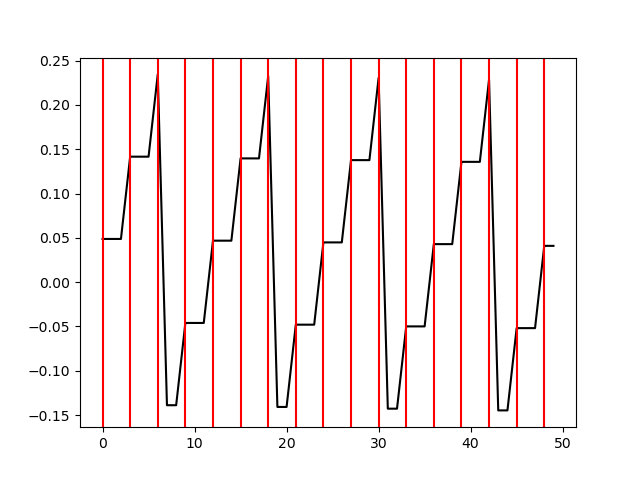

<IPython.core.display.Javascript object>


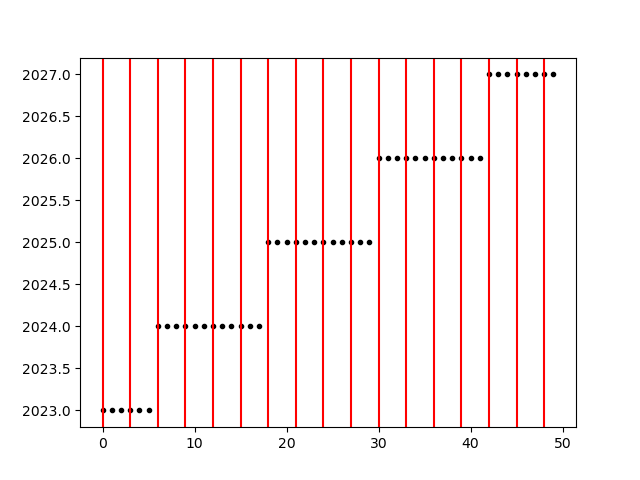

In [66]:
df_array = np.array(df_list)
dac_array = np.array(dac_list)
print(df_array.size)
print(dac_array.size)
xaxis = np.arange(0,limit)


plt.figure()
plt.plot(df_array, color = 'black')
if variation != 0 and variation != 1:
    for i in (xaxis[::variation]):
        plt.axvline(x=i, color = 'red')
plt.show()

plt.figure()
plt.plot(dac_array, '.', color = 'black')
if variation != 0 and variation != 1:
    for i in (xaxis[::variation]):
        plt.axvline(x=i, color = 'red')
plt.show()

In [1]:
import numpy as np

In [15]:
def test(a,b):
    """
    adds fhfhffh                                                                                                                           parameters"
    c = a+b
    return c
    """

print(test(1,2))
test?

None


<IPython.core.display.Javascript object>


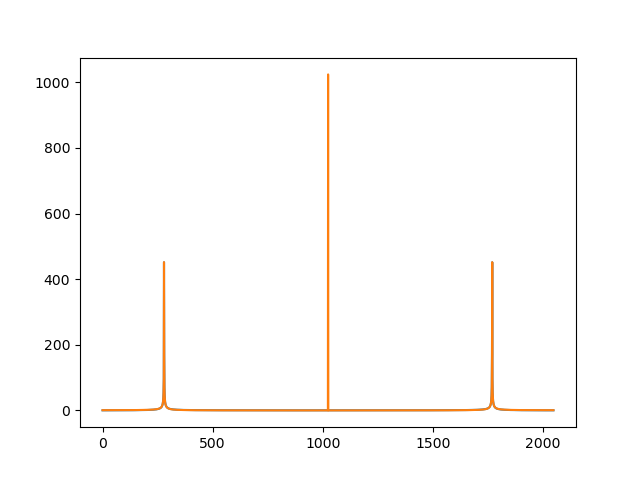

In [21]:
t = np.arange(0,2048)/2.2e6
sin = np.sin(2*np.pi*t*29e6)
lo = np.cos(2*np.pi*t*(29e6+0)) + 1j*np.sin(2*np.pi*t*(29e6+0))
fft_real = np.abs(np.fft.fft(sin*lo.real))
fft_imag = np.abs(np.fft.fft(sin*lo.imag))


plt.figure()
# plt.plot(sin*lo.real)
# plt.plot(sin*lo.imag)
# plt.plot(lo.real)
# plt.plot(lo.imag)
plt.plot(np.fft.fftshift(fft_real))
plt.plot(np.fft.fftshift(fft_imag))
plt.show()